# FINAL NPZD PROTOTYPE

# done:
- completely rewrote handling of fluxes, this time registered with decorator
- add option to include all output vars to phyda.setup wrapper!
- add "group" multi flux, that can be appended to modularly (i.e. growth with monod, light-lim, etc.)
    

# TODO 2day:
# - make "group" function work with the other solvers (Stepwise + GEKKO)

# - add "list input" of multiple vars for grazing flux!
    this could be done using a new variable type (i.e. a new type of input) that in the comp decorator
    is unpacked to multiple vars, that each get assigned their "part" of the flux
    maybe, this needs the "packed" input argument, that is assembled at "input var dict" creation
    
    so the way I implemented "group", passing a list to self.flux_input_args,
    this should be easily adapted to have a foreign=True, list_input=True
    
       hm, or maybe something more like phydra.variable(group_to_arg='resources')
       
     

In [1]:
import os,sys,inspect
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import phydra

In [2]:
from phydra.components.variables import SV
from phydra.components.fluxes import (LinearForcingInput, LinearMortalityExchange,
                                      QuadraticMortality,
                                      ExponentialGrowth, MonodGrowth,
                                      HollingTypeIII, HollingTypeIII_2Resources,
                                      Growth_Monod_Eppley_Steele)
from phydra.components.forcings import ConstantForcing, SinusoidalForcing, GlobalSlabClimatologyForcing

In [3]:
import numpy as np

In [4]:
NPZD = phydra.create({'Nutrient':SV, 
                      'Phytoplankton':SV,
                      'Zooplankton':SV,
                      'Detritus':SV,

                      'Input':LinearForcingInput, 
                      'Mortality':LinearMortalityExchange, 'QuadMortality':QuadraticMortality,

                      'Growth':Growth_Monod_Eppley_Steele,
                      'Grazing':HollingTypeIII_2Resources,
                      
                      # HERE NEED TO ADD THIS:
                      'N0':GlobalSlabClimatologyForcing,
                      'Tmld':GlobalSlabClimatologyForcing,
                      'I0':GlobalSlabClimatologyForcing,
                      'MLD':GlobalSlabClimatologyForcing
                     })

In [5]:
NPZD

<xsimlab.Model (16 processes, 64 inputs)>
Core
    solver_type       [in]
Time
    time              [in] ('input_time',) sequence of time points ...
Nutrient
    var_label         [in] label / basic state variable
    var_init          [in] initial value / basic state variable
Phytoplankton
    var_init          [in] initial value / basic state variable
    var_label         [in] label / basic state variable
Zooplankton
    var_init          [in] initial value / basic state variable
    var_label         [in] label / basic state variable
Detritus
    var_init          [in] initial value / basic state variable
    var_label         [in] label / basic state variable
MLD
    forcing_label     [in] label / 
    k                 [in] The degree of the spline fit
    rbb               [in] constant value of forcing
    dataset           [in] Options: 'n0x', 'mld', 'tmld', 'par'
    lon               [in] constant value of forcing
    smooth            [in] smoothing conditions, larger valu

'N0':{'lat':47,'lon':-20,'rbb':2,'smooth':5, 'k':2,
       'dataset':'n0x', 'show_plot':True},
'Temp':{'lat':47,'lon':-20,'rbb':2,'smooth':5, 'k':2,
       'dataset':'tmld', 'show_plot':True},
'I0':{'lat':47,'lon':-20,'rbb':2,'smooth':10, 'k':2,
       'dataset':'par', 'show_plot':True},
'MLD':{'lat':47,'lon':-20,'rbb':2,'smooth':400, 'k':2,
       'dataset':'mld', 'show_plot':True}

In [6]:
odeint_setup = phydra.setup('odeint', NPZD,
            time=np.arange(0,365*5),
            input_vars={
                'Nutrient':{'var_label':'N','var_init':1.},
                'Phytoplankton':{'var_label':'P','var_init':1.},
                'Zooplankton':{'var_label':'Z','var_init':1.},
                'Detritus':{'var_label':'D','var_init':1.},
                
                'Input':{'var':'N','rate':0.1, 'forcing':'N0'},
                
                'Mortality':{'source':'P', 'sink':'D', 'rate':0.1},
                'QuadMortality':{'var':'Z', 'rate':0.01},
                
                'Growth':{'consumer':'P', 'resource':'N', 
                          'Temp':'Tmld', 'Light':'I0', 'MLD':'MLD',
                          'kw':0.04, 'kc':0.03,
                          'μ_max':1., 'halfsat':1.5, 'eppley':0.063, 'i_opt':2},
                
                'Grazing':{'r_1':'P', 'r_2':'D', 'consumer':'Z',
                           'fp_1':.5, 'fp_2':.5,'Imax':1., 'kZ':1.5},
                
                'N0':{'forcing_label':'N0', 'dataset':'n0x',
                      'lat':47,'lon':-20,'rbb':2,
                      'smooth':5, 'k':2},
                'Tmld':{'forcing_label':'Tmld', 'dataset':'tmld',
                      'lat':47,'lon':-20,'rbb':2,
                      'smooth':5, 'k':2},
                'I0':{'forcing_label':'I0', 'dataset':'par',
                      'lat':47,'lon':-20,'rbb':2,
                      'smooth':10, 'k':2},
                'MLD':{'forcing_label':'MLD', 'dataset':'mld',
                      'lat':47,'lon':-20,'rbb':2,
                      'smooth':400, 'k':2},
            },
            output_vars="ALL"
            )

{'name': 'Nutrient__var_value', 'attrib': Attribute(name='var_value', default=NOTHING, validator=None, repr=False, eq=True, order=True, hash=None, init=False, metadata=mappingproxy({'var_type': <VarType.VARIABLE: 'variable'>, 'dims': (('time',),), 'intent': <VarIntent.OUT: 'out'>, 'groups': (), 'static': False, 'attrs': {'Phydra_store_out': True}, 'description': 'output of variable value / basic state variable', 'encoding': {}}), type=None, converter=None, kw_only=False), 'metadata': mappingproxy({'var_type': <VarType.VARIABLE: 'variable'>, 'dims': (('time',),), 'intent': <VarIntent.OUT: 'out'>, 'groups': (), 'static': False, 'attrs': {'Phydra_store_out': True}, 'description': 'output of variable value / basic state variable', 'encoding': {}}), 'value': None}
{'name': 'Phytoplankton__var_value', 'attrib': Attribute(name='var_value', default=NOTHING, validator=None, repr=False, eq=True, order=True, hash=None, init=False, metadata=mappingproxy({'var_type': <VarType.VARIABLE: 'variable'>,

In [7]:
with NPZD:
    odeint_out = odeint_setup.xsimlab.run()

initializing model backend
Initializing Model Time
Initializing component Nutrient
Initializing component Phytoplankton
Initializing component Zooplankton
Initializing component Detritus
Initializing component MLD
Initializing component I0
Initializing component Tmld
Initializing component N0
Initializing component Input
Initializing component Mortality
Initializing component QuadMortality
Initializing component Growth
Initializing component Grazing
assembling model
SOLVER : <phydra.backend.solvers.ODEINTSolver object at 0x110055a60>
variables time (1825,)
variables N (1825,)
variables P (1825,)
variables Z (1825,)
variables D (1825,)
values Time_time_flux (1825,)
values Input_input (1825,)
values Mortality_death (1825,)
values QuadMortality_death (1825,)
values Growth_growth (1825,)
values Grazing_grazing (1825,)
values Grazing_r1_out (1825,)
values Grazing_r2_out (1825,)
Model is assembled:
Model contains: 
Variables:['time', 'N', 'P', 'Z', 'D'] 
Parameters:['MLD_dataset', 'MLD_lat',

In [9]:
odeint_out

<xarray.Dataset>
Dimensions:                     (clock: 2, input_time: 1825, time: 1825)
Coordinates:
  * clock                       (clock) int64 0 1
Dimensions without coordinates: input_time, time
Data variables:
    Core__solver_type           <U6 'odeint'
    Detritus__var_init          float64 1.0
    Detritus__var_label         <U1 'D'
    Detritus__var_value         (time) float64 1.0 0.929 ... 0.1889 0.1892
    Grazing__Imax               float64 1.0
    Grazing__consumer           <U1 'Z'
    Grazing__fp_1               float64 0.5
    Grazing__fp_2               float64 0.5
    Grazing__grazing_value      (time) float64 0.3077 0.3434 ... 0.3428 0.3372
    Grazing__kZ                 float64 1.5
    Grazing__r1_out_value       (time) float64 0.1538 0.1743 ... 0.2957 0.2903
    Grazing__r2_out_value       (time) float64 0.1538 0.1691 ... 0.04709 0.04684
    Grazing__r_1                <U1 'P'
    Grazing__r_2                <U1 'D'
    Growth__Light               <U2 'I0'
    Growth__MLD                 <U3 'MLD'
    Growth__Temp                <U4 'Tmld'
    Growth__consumer            <U1 'P'
    Growth__eppley              float64 0.063
    Growth__growth_value        (time) float64 0.2194 0.2326 ... 0.3405 0.3349
    Growth__halfsat             float64 1.5
    Growth__i_opt               int64 2
    Growth__kc                  float64 0.03
    Growth__kw                  float64 0.04
    Growth__resource            <U1 'N'
    Growth__μ_max               float64 1.0
    I0__dataset                 <U3 'par'
    I0__forcing_label           <U2 'I0'
    I0__forcing_value           (time) float64 7.521 7.594 7.672 ... 7.388 7.452
    I0__k                       int64 2
    I0__lat                     int64 47
    I0__lon                     int64 -20
    I0__rbb                     int64 2
    I0__smooth                  int64 10
    Input__forcing              <U2 'N0'
    Input__input_value          (time) float64 0.509 0.5111 ... 0.4981 0.5025
    Input__rate                 float64 0.1
    Input__var                  <U1 'N'
    MLD__dataset                <U3 'mld'
    MLD__forcing_label          <U3 'MLD'
    MLD__forcing_value          (time) float64 160.4 162.2 164.0 ... 156.8 158.6
    MLD__k                      int64 2
    MLD__lat                    int64 47
    MLD__lon                    int64 -20
    MLD__rbb                    int64 2
    MLD__smooth                 int64 400
    Mortality__death_value      (time) float64 0.1 0.09812 ... 0.04732 0.04707
    Mortality__rate             float64 0.1
    Mortality__sink             <U1 'D'
    Mortality__source           <U1 'P'
    N0__dataset                 <U3 'n0x'
    N0__forcing_label           <U2 'N0'
    N0__forcing_value           (time) float64 5.09 5.133 5.175 ... 5.003 5.047
    N0__k                       int64 2
    N0__lat                     int64 47
    N0__lon                     int64 -20
    N0__rbb                     int64 2
    N0__smooth                  int64 5
    Nutrient__var_init          float64 1.0
    Nutrient__var_label         <U1 'N'
    Nutrient__var_value         (time) float64 1.0 1.279 1.543 ... 94.82 94.98
    Phytoplankton__var_init     float64 1.0
    Phytoplankton__var_label    <U1 'P'
    Phytoplankton__var_value    (time) float64 1.0 0.9602 ... 0.472 0.4695
    QuadMortality__death_value  (time) float64 0.01 0.01354 ... 0.3951 0.3886
    QuadMortality__rate         float64 0.01
    QuadMortality__var          <U1 'Z'
    Time__time                  (input_time) int64 0 1 2 3 ... 1822 1823 1824
    Tmld__dataset               <U4 'tmld'
    Tmld__forcing_label         <U4 'Tmld'
    Tmld__forcing_value         (time) float64 13.36 13.33 13.29 ... 13.43 13.39
    Tmld__k                     int64 2
    Tmld__lat                   int64 47
    Tmld__lon                   int64 -20
    Tmld__rbb                   int64 2
    Tmld__smooth                int64 5
    Zooplankton__var_init       float64 1.0
    Zoo

In [10]:
import matplotlib.pyplot as plt

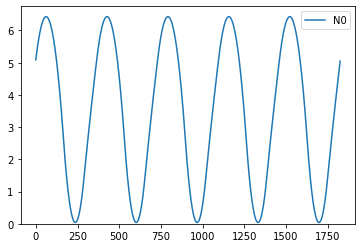

In [11]:
time = odeint_out.Time__time
plt.plot(time, odeint_out.N0__forcing_value, label='N0')
plt.ylim(bottom=0)
plt.legend()

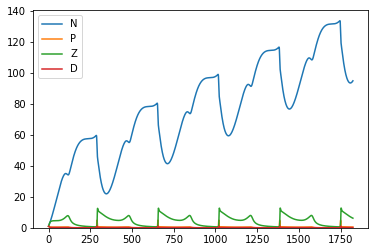

In [12]:
time = odeint_out.Time__time
plt.plot(time, odeint_out.Nutrient__var_value, label='N')
plt.plot(time, odeint_out.Phytoplankton__var_value, label='P')
plt.plot(time, odeint_out.Zooplankton__var_value, label='Z')
plt.plot(time, odeint_out.Detritus__var_value, label='D')
plt.ylim(bottom=0)
plt.legend()

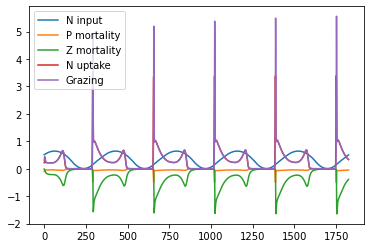

In [13]:
plt.plot(time, odeint_out.Input__input_value, label='N input')
plt.plot(time, -odeint_out.Mortality__death_value, label='P mortality')
plt.plot(time, -odeint_out.QuadMortality__death_value, label='Z mortality')
plt.plot(time, odeint_out.Growth__growth_value, label='N uptake')
plt.plot(time, odeint_out.Grazing__grazing_value, label='Grazing')
#plt.ylim(bottom=0)
plt.legend()

In [14]:
stepwise_setup = phydra.update_setup(model=NPZD, old_setup=odeint_setup, new_solver="stepwise")

In [15]:
with NPZD:
    stepwise_out = stepwise_setup.xsimlab.run()

initializing model backend
Initializing Model Time
Initializing component Nutrient
Initializing component Phytoplankton
Initializing component Zooplankton
Initializing component Detritus
Initializing component MLD
Initializing component I0
Initializing component Tmld
Initializing component N0
Initializing component Input
Initializing component Mortality
Initializing component QuadMortality
Initializing component Growth
Initializing component Grazing
assembling model
SOLVER : <phydra.backend.solvers.StepwiseSolver object at 0x15ff8b700>
Model is assembled:
Model contains: 
Variables:['time', 'N', 'P', 'Z', 'D'] 
Parameters:['MLD_dataset', 'MLD_lat', 'MLD_lon', 'MLD_rbb', 'MLD_smooth', 'MLD_k', 'I0_dataset', 'I0_lat', 'I0_lon', 'I0_rbb', 'I0_smooth', 'I0_k', 'Tmld_dataset', 'Tmld_lat', 'Tmld_lon', 'Tmld_rbb', 'Tmld_smooth', 'Tmld_k', 'N0_dataset', 'N0_lat', 'N0_lon', 'N0_rbb', 'N0_smooth', 'N0_k', 'Input_rate', 'Mortality_rate', 'QuadMortality_rate', 'Growth_halfsat', 'Growth_eppley', 'G

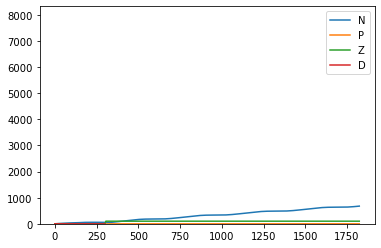

In [16]:
time = stepwise_out.Time__time
plt.plot(time, stepwise_out.Nutrient__var_value, label='N')
plt.plot(time, stepwise_out.Phytoplankton__var_value, label='P')
plt.plot(time, stepwise_out.Zooplankton__var_value, label='Z')
plt.plot(time, stepwise_out.Detritus__var_value, label='D')
plt.ylim(bottom=0)
plt.legend()

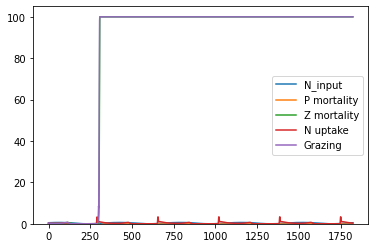

In [17]:
plt.plot(time, stepwise_out.Input__input_value, label='N_input')
plt.plot(time, stepwise_out.Mortality__death_value, label='P mortality')
plt.plot(time, stepwise_out.QuadMortality__death_value, label='Z mortality')
plt.plot(time, odeint_out.Growth__growth_value, label='N uptake')
plt.plot(time, stepwise_out.Grazing__grazing_value, label='Grazing')
plt.ylim(bottom=0)
plt.legend()

In [18]:
gekko_setup = phydra.update_setup(model=NPZD, 
                                  old_setup=odeint_setup, 
                                  new_solver="gekko", 
                                  # gekko solver works better (much faster) with smaller time steps:
                                  # new_time=np.arange(0,201,.1)
                                 )

In [19]:
with NPZD:
    gekko_out = gekko_setup.xsimlab.run()

initializing model backend
Initializing Model Time
adding variable here:
time
<class 'gekko.gk_variable.GK_SV'>
adding flux
Initializing component Nutrient
adding variable here:
n
<class 'gekko.gk_variable.GK_SV'>
Initializing component Phytoplankton
adding variable here:
p
<class 'gekko.gk_variable.GK_SV'>
Initializing component Zooplankton
adding variable here:
z
<class 'gekko.gk_variable.GK_SV'>
Initializing component Detritus
adding variable here:
d
<class 'gekko.gk_variable.GK_SV'>
Initializing component MLD
adding parameter:
adding parameter:
mld_lat
adding parameter:
mld_lon
adding parameter:
mld_rbb
adding parameter:
mld_smooth
adding parameter:
mld_k
Initializing component I0
adding parameter:
adding parameter:
i0_lat
adding parameter:
i0_lon
adding parameter:
i0_rbb
adding parameter:
i0_smooth
adding parameter:
i0_k
Initializing component Tmld
adding parameter:
adding parameter:
tmld_lat
adding parameter:
tmld_lon
adding parameter:
tmld_rbb
adding parameter:
tmld_smooth
addin

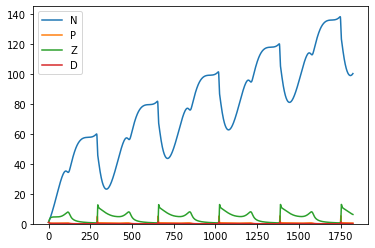

In [20]:
time = gekko_out.Time__time
plt.plot(time, gekko_out.Nutrient__var_value, label='N')
plt.plot(time, gekko_out.Phytoplankton__var_value, label='P')
plt.plot(time, gekko_out.Zooplankton__var_value, label='Z')
plt.plot(time, gekko_out.Detritus__var_value, label='D')
plt.ylim(bottom=0)
plt.legend()

AttributeError: 'Dataset' object has no attribute 'NutrientUptake__uptake_value'

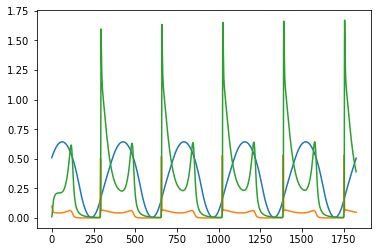

In [21]:
plt.plot(time, gekko_out.Input__input_value, label='N_input')
plt.plot(time, gekko_out.Mortality__death_value, label='P mortality')
plt.plot(time, gekko_out.QuadMortality__death_value, label='Z mortality')
plt.plot(time, gekko_out.NutrientUptake__uptake_value, label='N uptake')
plt.plot(time, gekko_out.Grazing__grazing_value, label='Grazing')
plt.ylim(bottom=0)
plt.legend()